In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Callable
import functools
import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import numpy as np
import lovelyplots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
plt.style.use('ipynb')

from freedom.tensor_products import gaunt_tensor_product_utils as gtp_utils

In [3]:
jax.config.update("jax_enable_x64", True)

In [4]:
theta = jnp.asarray(jnp.pi / 2)
sh_theta_comp_expected = jnp.asarray([
    jnp.sqrt(1 / (4 * jnp.pi)),
    jnp.sqrt(3 / (8 * jnp.pi)) * jnp.sin(theta),
    jnp.sqrt(3 / (4 * jnp.pi)) * jnp.cos(theta),
    jnp.sqrt(3 / (8 * jnp.pi)) * jnp.sin(theta),
])
sh_theta_comps = jnp.asarray([
    gtp_utils.sh_theta(0, 0, theta),
    gtp_utils.sh_theta(1, -1, theta),
    gtp_utils.sh_theta(1, 0, theta),
    gtp_utils.sh_theta(1, 1, theta)
])
sh_theta_comp_expected, sh_theta_comps

(Array([2.82094792e-01, 3.45494149e-01, 2.99182751e-17, 3.45494149e-01],      dtype=float64),
 Array([2.82094792e-01, 3.45494149e-01, 2.99182751e-17, 3.45494149e-01],      dtype=float64))

Check that the SH match expected values upto l = 2.

In [5]:
grid_kwargs = dict(res_theta=100, res_phi=100)
lmax = 2

In [6]:
expected_Y = {
    (0, 0): lambda theta, phi: jnp.sqrt(1/(4 * jnp.pi)),
    (1, -1): lambda theta, phi: jnp.sin(theta) * jnp.sin(phi) * jnp.sqrt(3/(4 * jnp.pi)),
    (1, 0): lambda theta, phi: jnp.cos(theta) * jnp.sqrt(3/(4 * jnp.pi)),
    (1, 1): lambda theta, phi: jnp.sin(theta) * jnp.cos(phi) * jnp.sqrt(3/(4 * jnp.pi)),
    (2, -2): lambda theta, phi: jnp.sin(theta)**2 * jnp.sin(2 * phi) * jnp.sqrt(15/(16 * jnp.pi)),
    (2, -1): lambda theta, phi: jnp.sin(theta) * jnp.cos(theta) * jnp.sin(phi) * jnp.sqrt(15/(4 * jnp.pi)),
    (2, 0): lambda theta, phi: (3 * jnp.cos(theta)**2 - 1) * jnp.sqrt(5/(16 * jnp.pi)),
    (2, 1): lambda theta, phi: jnp.sin(theta) * jnp.cos(theta) * jnp.cos(phi) * jnp.sqrt(15/(4 * jnp.pi)),
    (2, 2): lambda theta, phi: jnp.sin(theta)**2 * jnp.cos(2 * phi) * jnp.sqrt(15/(16 * jnp.pi)),
}

failed = []
for l in range(lmax + 1):
    for m in range(-l, l + 1):
        expected = gtp_utils.RectangularSignal.from_function(expected_Y[(l, m)], **grid_kwargs, wrap_theta=False)
        actual = gtp_utils.create_spherical_harmonic_signal(l, m, **grid_kwargs)

        if not jnp.allclose(actual.grid_values, expected.grid_values, atol=1e-5):
            max_diff = jnp.abs(actual.grid_values - expected.grid_values).max()
            print(f"l={l}, m={m} failed, max_diff={max_diff}")
            
            failed_theta, failed_phi = jnp.unravel_index(jnp.argmax(jnp.abs(actual.grid_values - expected.grid_values)), actual.grid_values.shape)
            print(f"Failed at theta={actual.thetas()[failed_theta]}, phi={actual.phis()[failed_phi]}: actual={actual.grid_values[failed_theta, failed_phi]}, expected={expected.grid_values[failed_theta, failed_phi]}")
            failed.append((l, m))

if not failed:
    print("All tests passed")

All tests passed


In [7]:
grid_kwargs = dict(res_theta=100, res_phi=100)


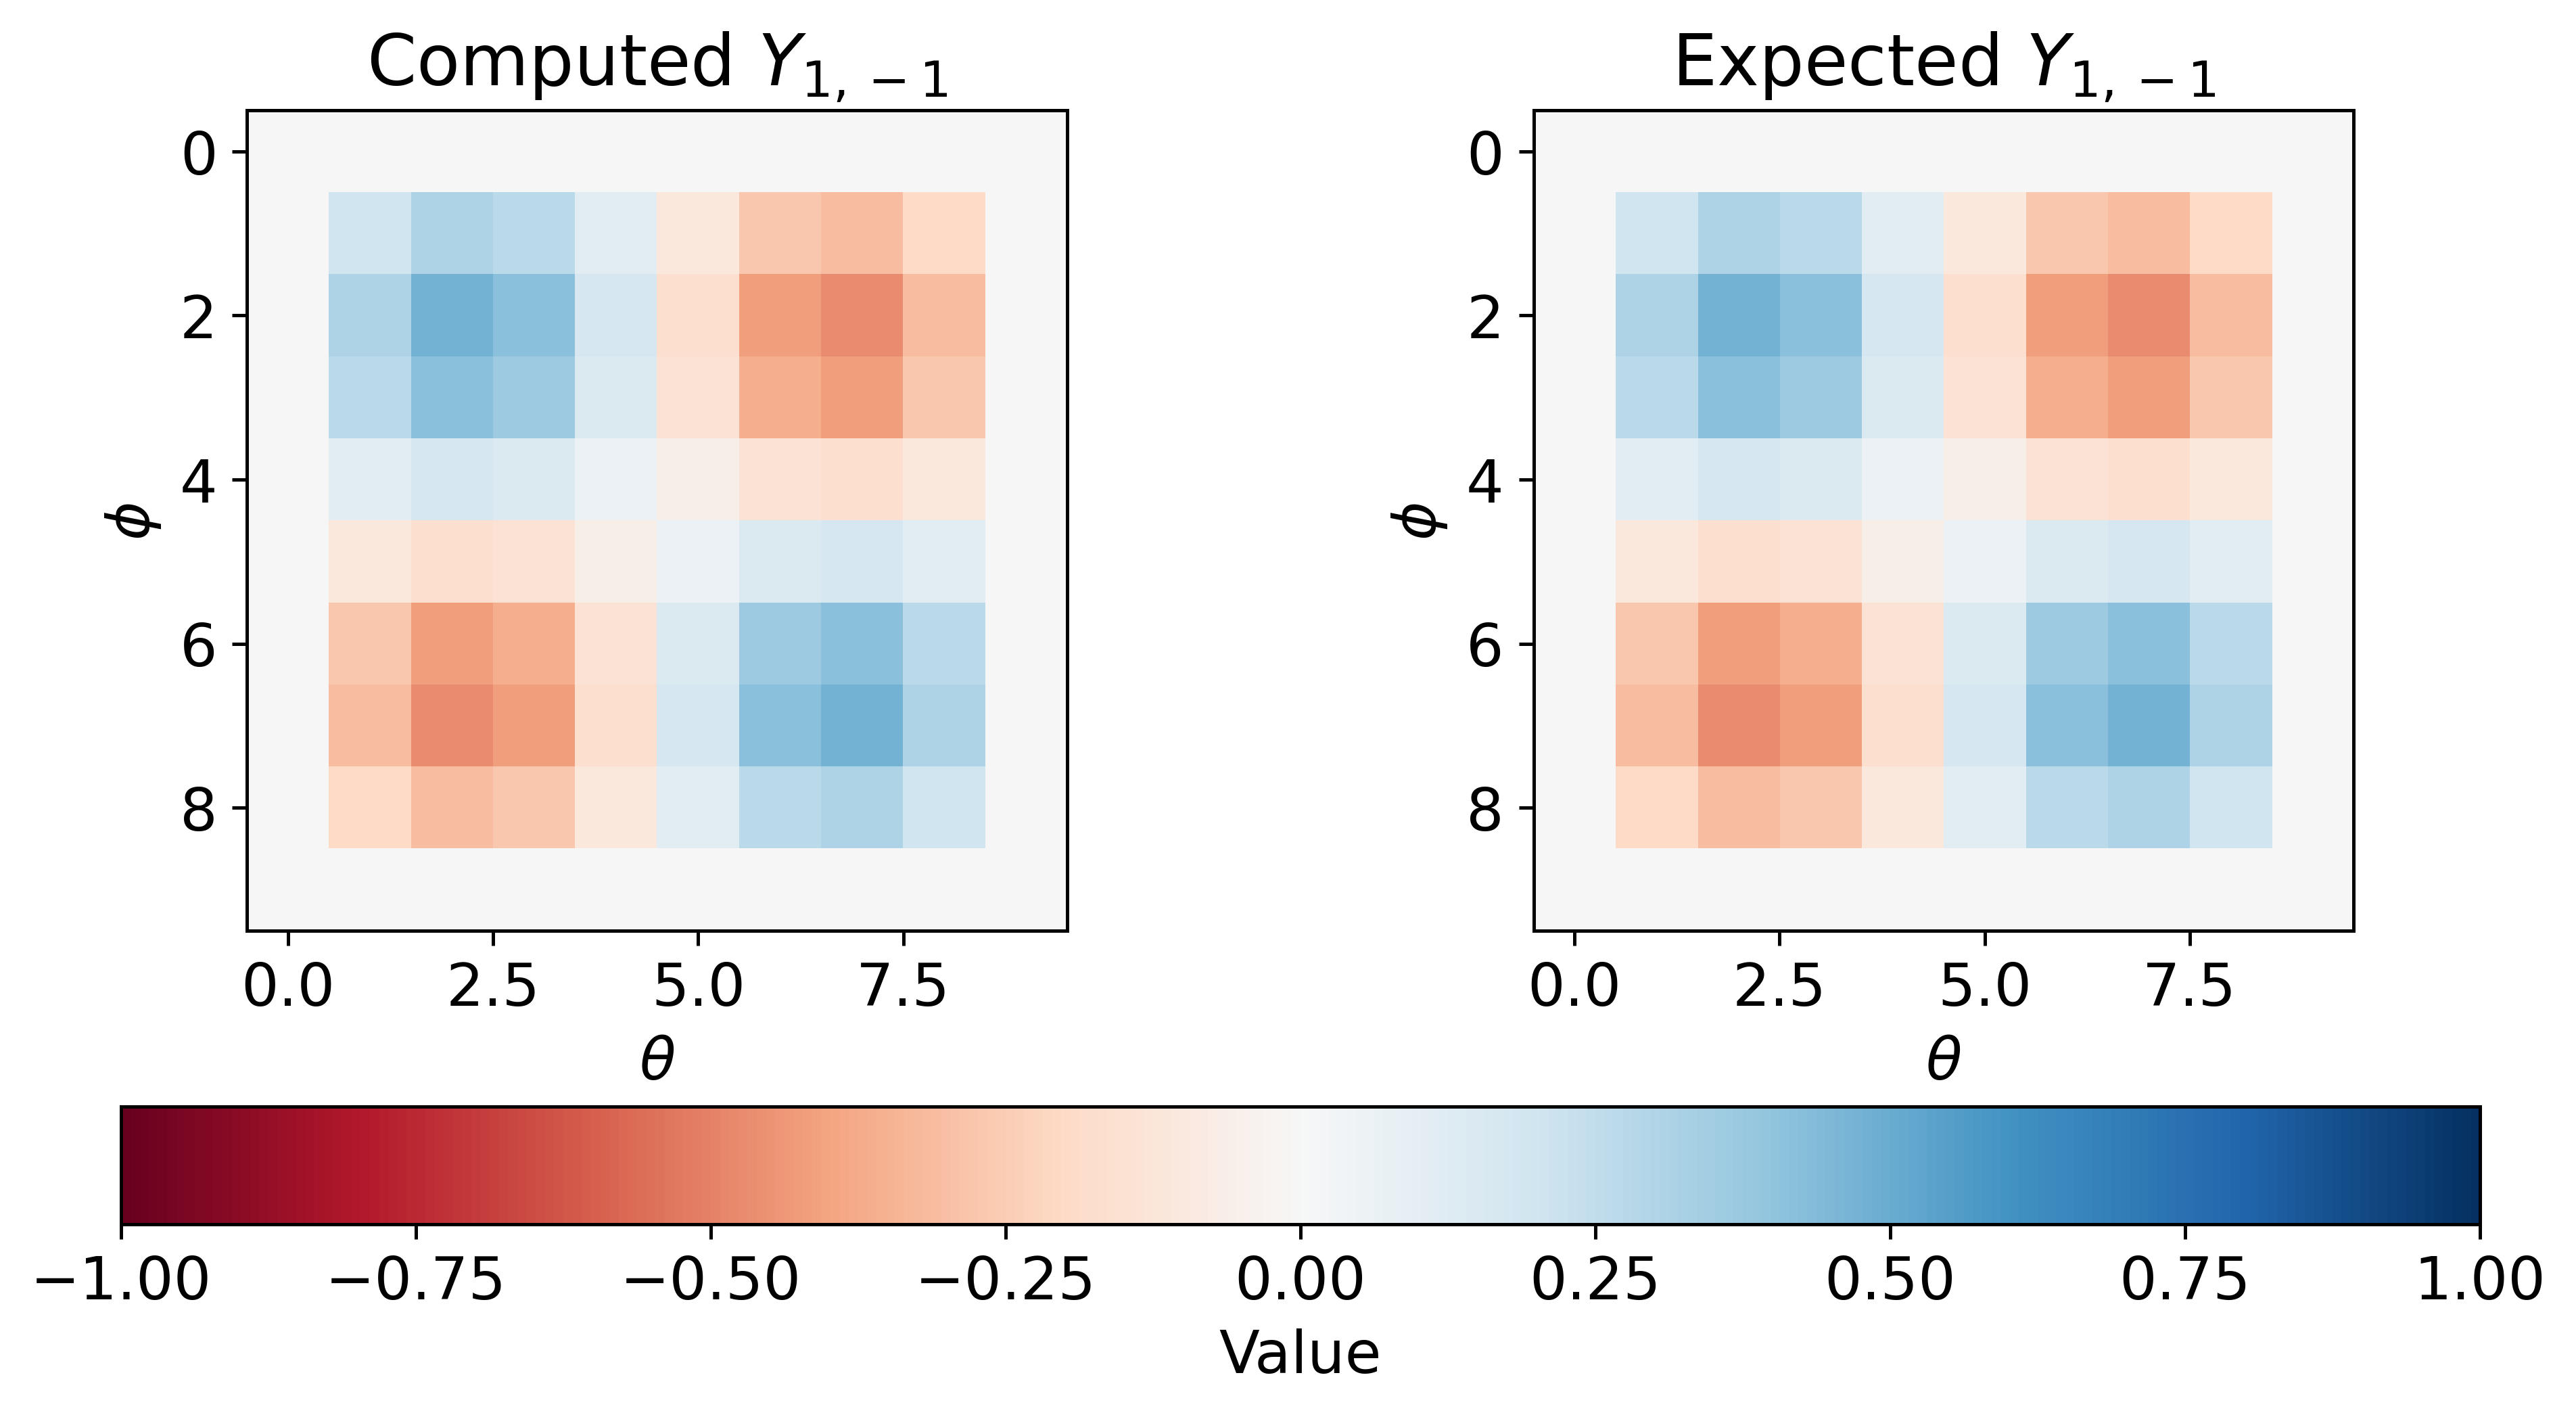

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

axs[0].imshow(gtp_utils.create_spherical_harmonic_signal(1, -1, res_theta=10, res_phi=10).grid_values.T, cmap='RdBu', vmin=-1, vmax=1)
axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"$\phi$")
axs[0].set_title(r"Computed $Y_{1,-1}$")

axs[1].imshow(gtp_utils.RectangularSignal.from_function(expected_Y[(1, -1)], res_theta=10, res_phi=10, wrap_theta=False).grid_values.T, cmap='RdBu', vmin=-1, vmax=1)
axs[1].set_xlabel(r"$\theta$")
axs[1].set_ylabel(r"$\phi$")
axs[1].set_title(r"Expected $Y_{1,-1}$")
fig.colorbar(mappable=axs[0].images[0], ax=axs, orientation='horizontal', label='Value')
plt.show()

# Spherical harmonics in the basis of 2D Fourier functions

$Y_{lm}(\theta, \phi) = \sum_{u,v} ({y^{lm}_{uv}})^* \exp{i (u \theta + v \phi)}$

so:

$
{y^{lm}_{uv}} = \frac{1}{2\pi} \int_0^{2\pi} \int_0^{2\pi} Y_{lm}(\theta, \phi) \exp{i (u \theta + v \phi)}  d\phi d\theta
$


In [9]:
u, v = 1, 0
F_signal = gtp_utils.RectangularSignal.from_function(gtp_utils.2D_fourier(u, v), **grid_kwargs, wrap_theta=False)
Y_signal = gtp_utils.RectangularSignal.from_function(lambda theta, phi: 1, **grid_kwargs, wrap_theta=False)
YF_signal = Y_signal * F_signal
YF_signal.integrate(area_element="spherical"), YF_signal.integrate(area_element="rectangular")

(Array(0.00050265+1.57076438j, dtype=complex128),
 Array(1.77090296e-16-3.54180592e-16j, dtype=complex128))

In [10]:
failed = []
for u in range(-lmax, lmax + 1):
    for v in range(-lmax, lmax + 1):
        F_signal = gtp_utils.RectangularSignal.from_function(gtp_utils.2D_fourier(u, v), **grid_kwargs, wrap_theta=False)
        F_signal_conj = gtp_utils.RectangularSignal.from_function(lambda theta, phi: jnp.conj(gtp_utils.2D_fourier(u, v)(theta, phi)), **grid_kwargs, wrap_theta=False)
        integral = (F_signal * F_signal_conj).integrate(area_element="rectangular")

        if not jnp.allclose(integral, 1):
            print(f"Failed: u={u}, v={v}, integral={integral}")
            failed.append((u, v))
if not failed:
    print("All tests passed")

All tests passed


In [11]:
lmax = 4
y_grid = gtp_utils.compute_y_grid(lmax, **grid_kwargs)

/Users/ameyad/Documents/vector-spherical-harmonics/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/ameyad/Documents/vector-spherical-harmonics/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/ameyad/Documents/vector-spherical-harmonics/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases thi

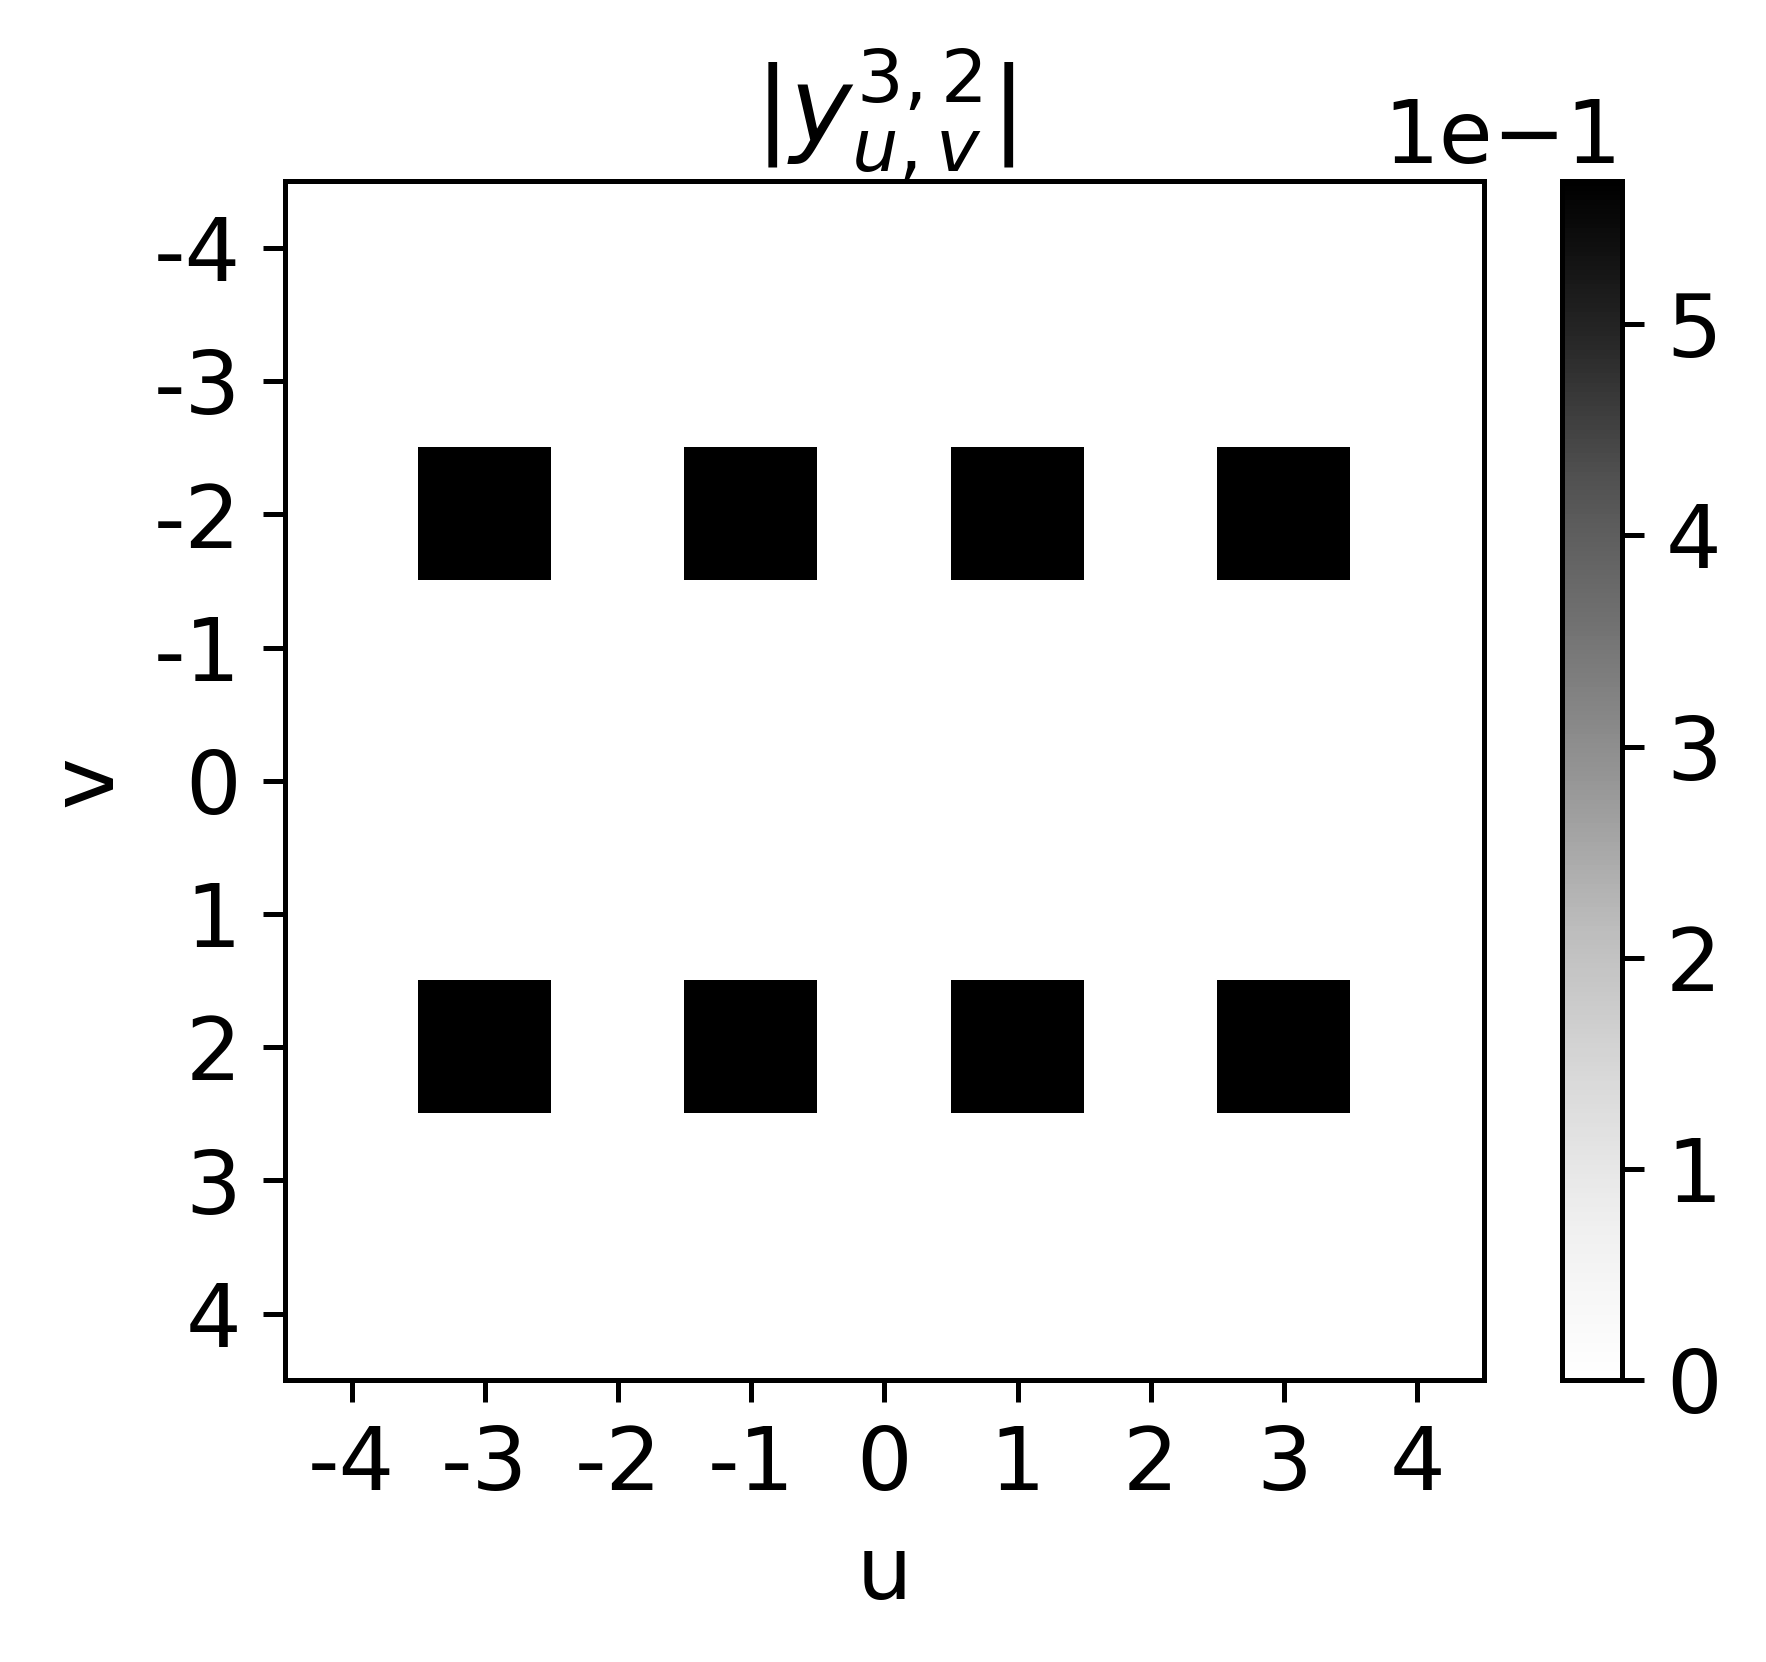

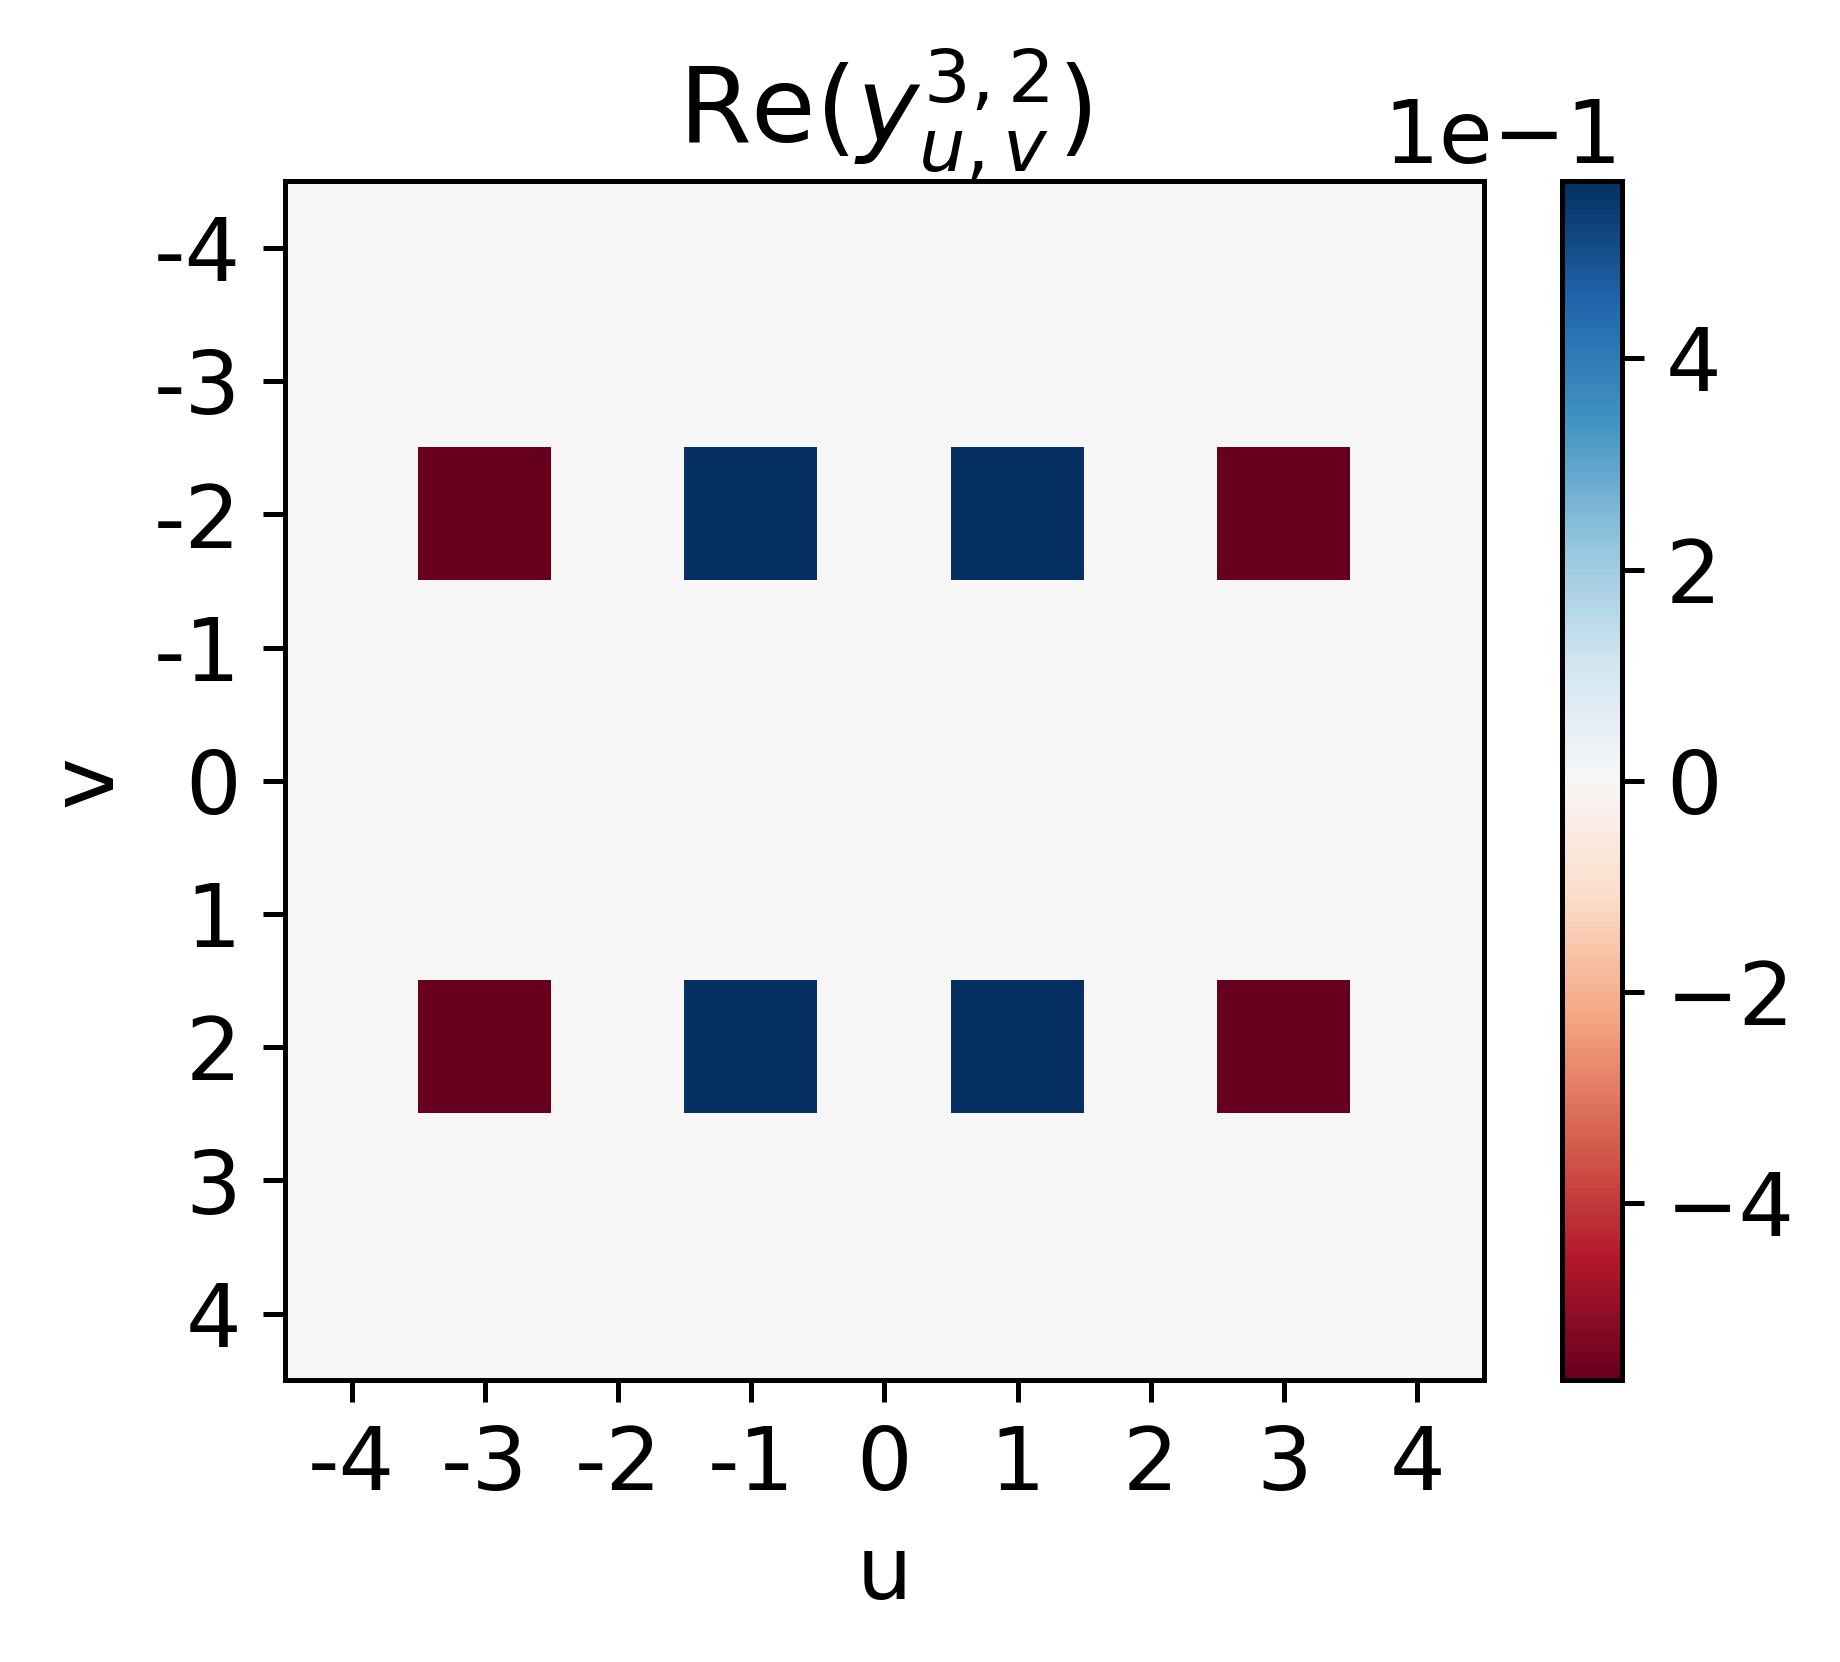

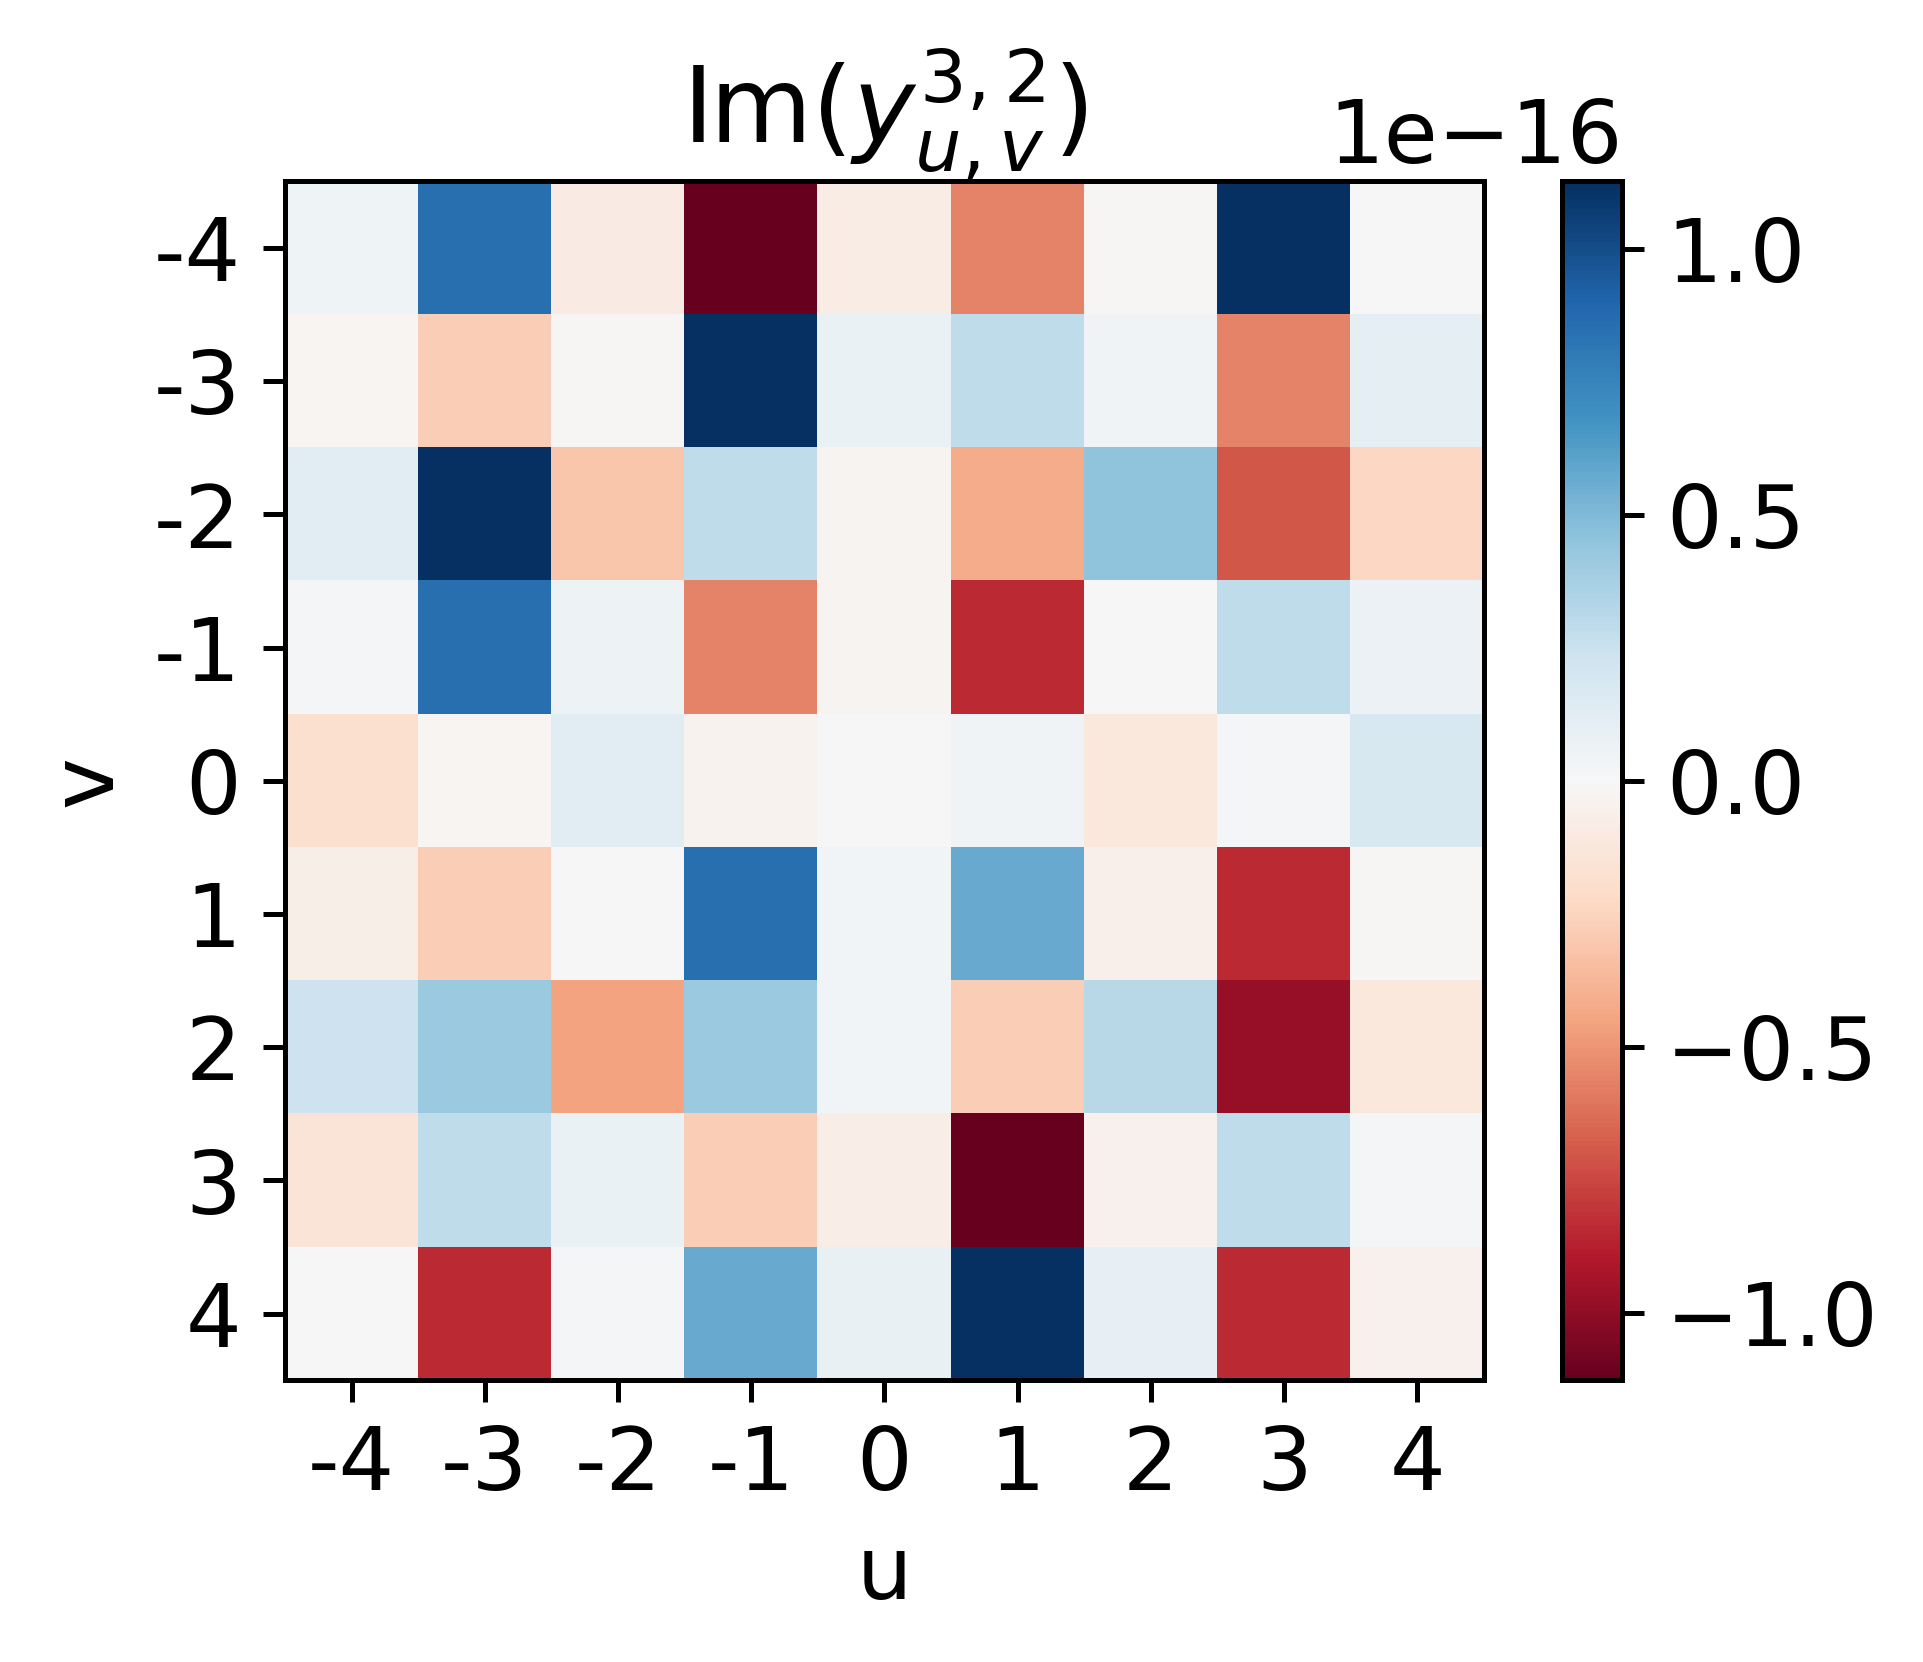

In [12]:
l, m = 3, 2
assert jnp.abs(m) <= l
y_lm = y_grid[gtp_utils.to_lm_index(l, m)]

plt.imshow(jnp.abs(y_lm).T, cmap="Grays", vmin=0)
plt.title("$|y_{{u, v}}^{{%d,%d}}|$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()


norm = mcolors.TwoSlopeNorm(vmin=-jnp.real(y_lm).max(), vcenter=0, vmax=jnp.real(y_lm).max())
plt.imshow(jnp.real(y_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Re}}(y_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()


norm = mcolors.TwoSlopeNorm(vmin=-jnp.imag(y_lm).max(), vcenter=0, vmax=jnp.imag(y_lm).max())
plt.imshow(jnp.imag(y_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Im}}(y_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()

# 2D Fourier functions Spherical harmonics in the basis of spherical harmonics


This means an extra factor of $\sin(\theta)$ in the integral.

$\exp{i (u \theta + v \phi)} = \sum_{u,v} {z^{lm}_{uv}} Y_{lm}(\theta, \phi) $

so:

$
{z^{lm}_{uv}} = \frac{1}{\sqrt{4\pi}} \int_0^{\pi} \int_0^{2\pi} Y_{lm}(\theta, \phi) \exp{i (u \theta + v \phi)} \sin \theta d\phi d\theta
$


In [13]:
failed = []
for l in range(0, lmax + 1):
    for m in range(-l, l + 1):
        Y_signal = gtp_utils.create_spherical_harmonic_signal(l, m, **grid_kwargs)
        integral = (Y_signal * Y_signal).integrate(area_element="spherical")
        if not jnp.allclose(integral, 1, rtol=1e-2):
            print(f"Failed: l={l}, m={m}, integral={integral}")
            failed.append((l, m))
if not failed:
    print("All tests passed")

All tests passed


In [14]:
Y_signal = gtp_utils.RectangularSignal.from_function(
    lambda theta, phi: jnp.sin(theta) * jnp.cos(phi) * jnp.sqrt(3/(4*jnp.pi)),
    **grid_kwargs, wrap_theta=False)
F_signal = gtp_utils.RectangularSignal.from_function(
    gtp_utils.2D_fourier(1, 1),
    **grid_kwargs, wrap_theta=False)
(Y_signal * F_signal).integrate(area_element="spherical")


Array(7.80019118e-06+0.32573476j, dtype=complex128)

In [15]:
lmax = 2
big_z_grid = gtp_utils.compute_z_grid(2 * lmax, **grid_kwargs)
z_grid = gtp_utils.compute_z_grid(lmax, **grid_kwargs)
y_grid = gtp_utils.compute_y_grid(lmax, **grid_kwargs)

z_grid.shape, y_grid.shape

/Users/ameyad/Documents/vector-spherical-harmonics/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


((9, 5, 5), (9, 5, 5))

In [16]:
l, m = 2, 1
(z_grid[gtp_utils.to_lm_index(l, m)] * y_grid[gtp_utils.to_lm_index(l, m)].conj()).sum()

Array(0.9999962-3.9719137e-34j, dtype=complex64)

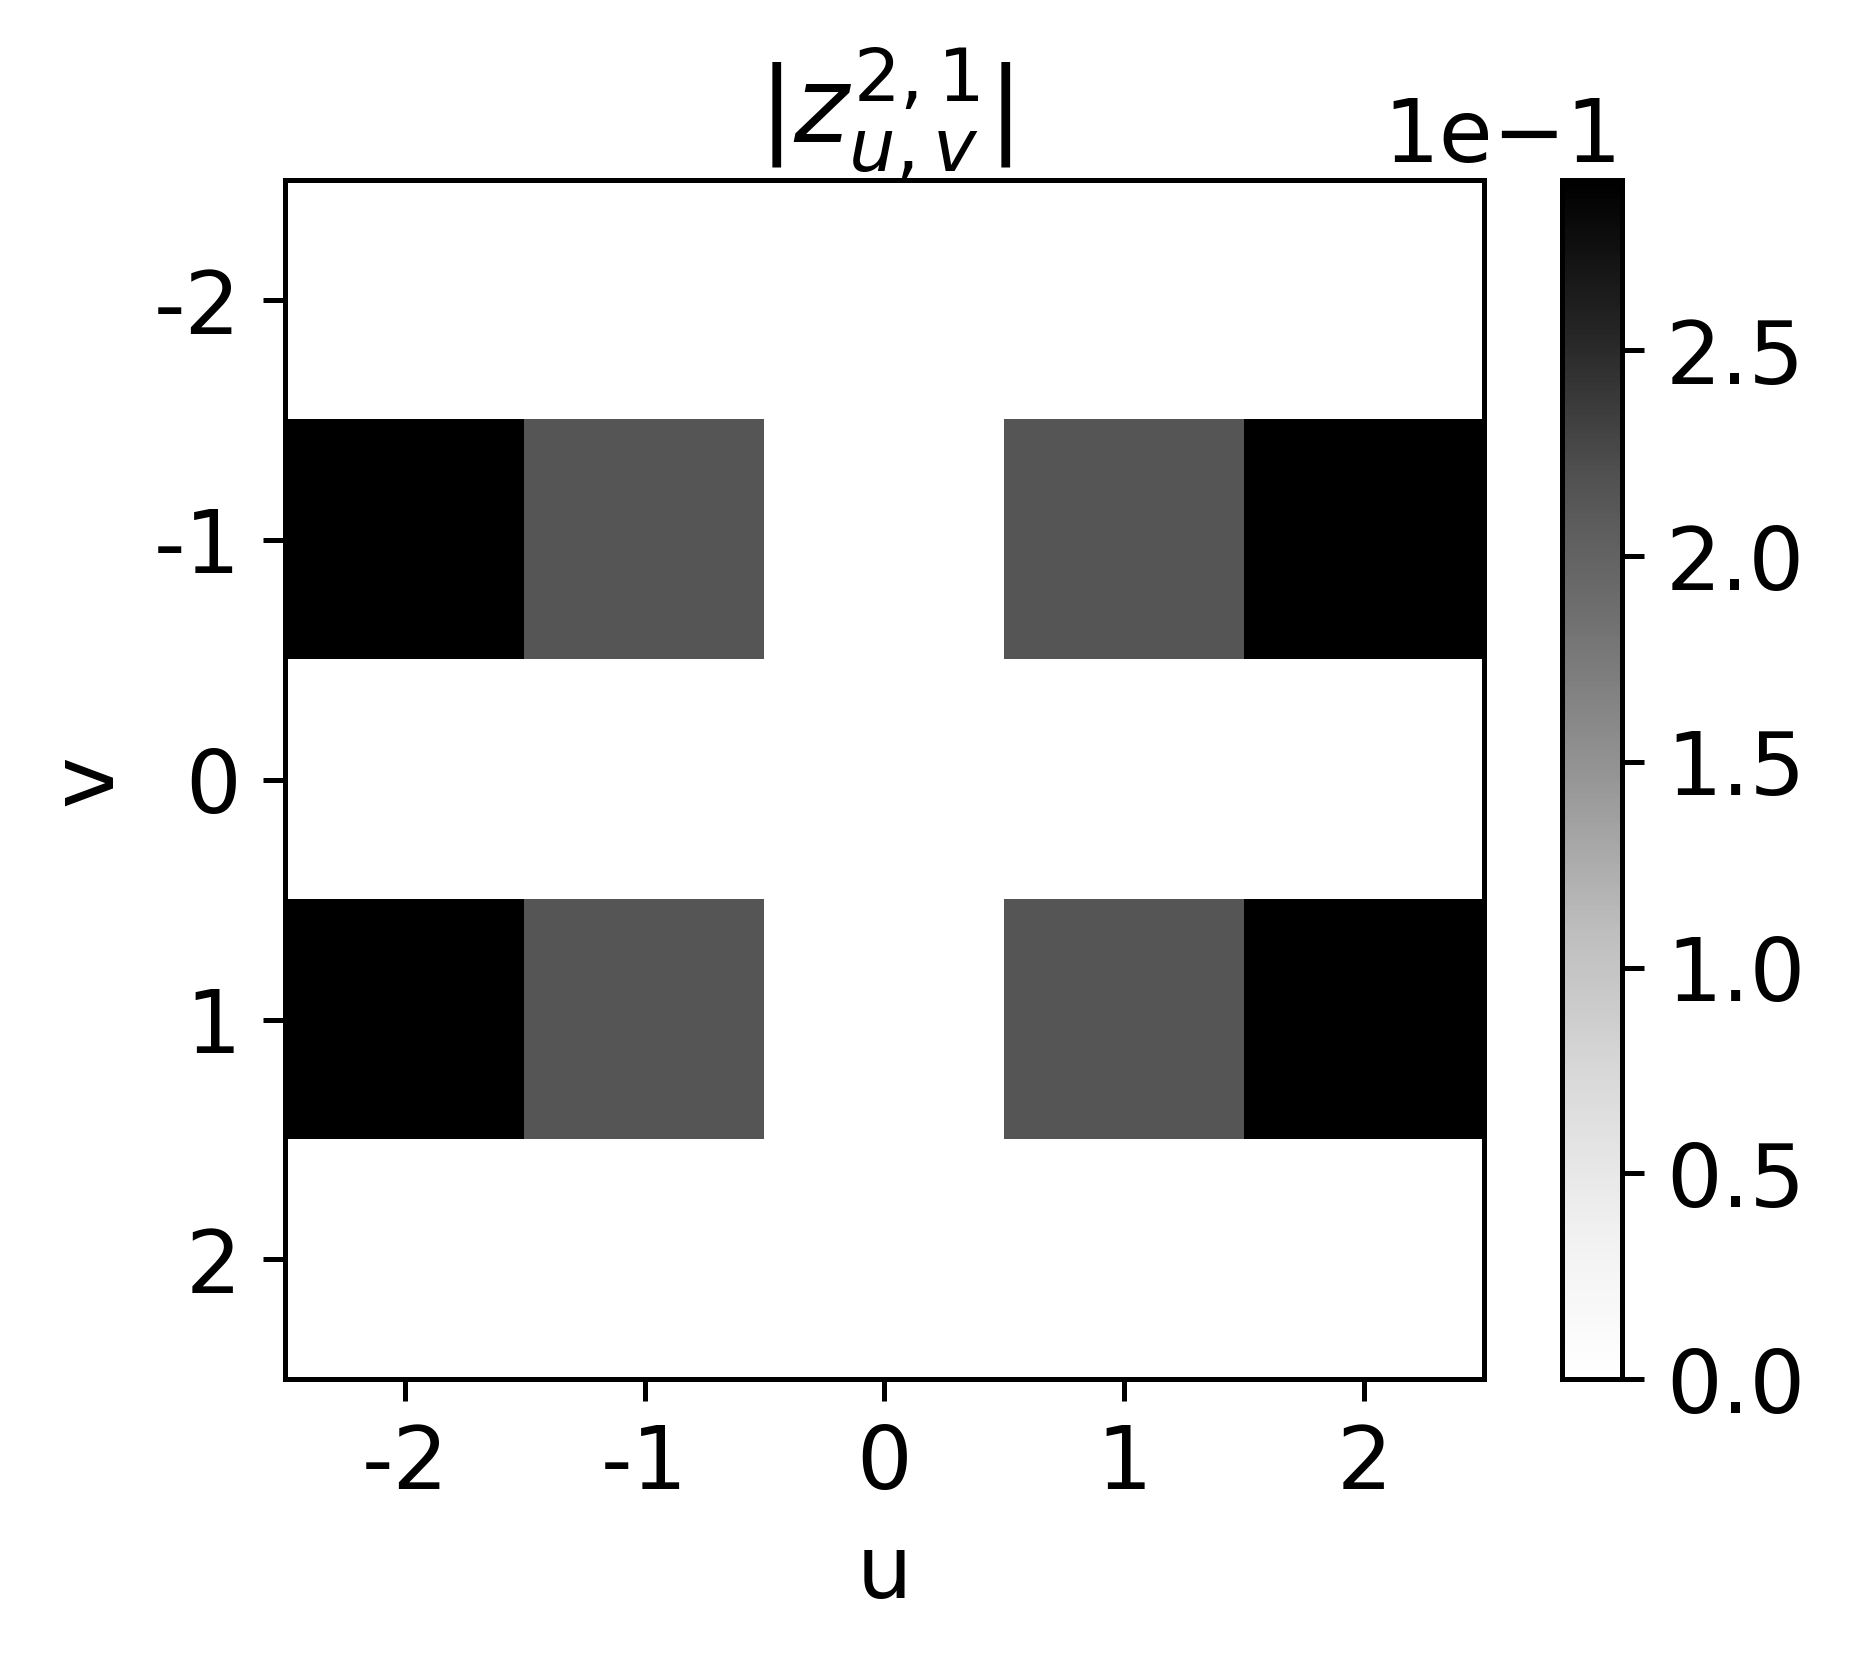

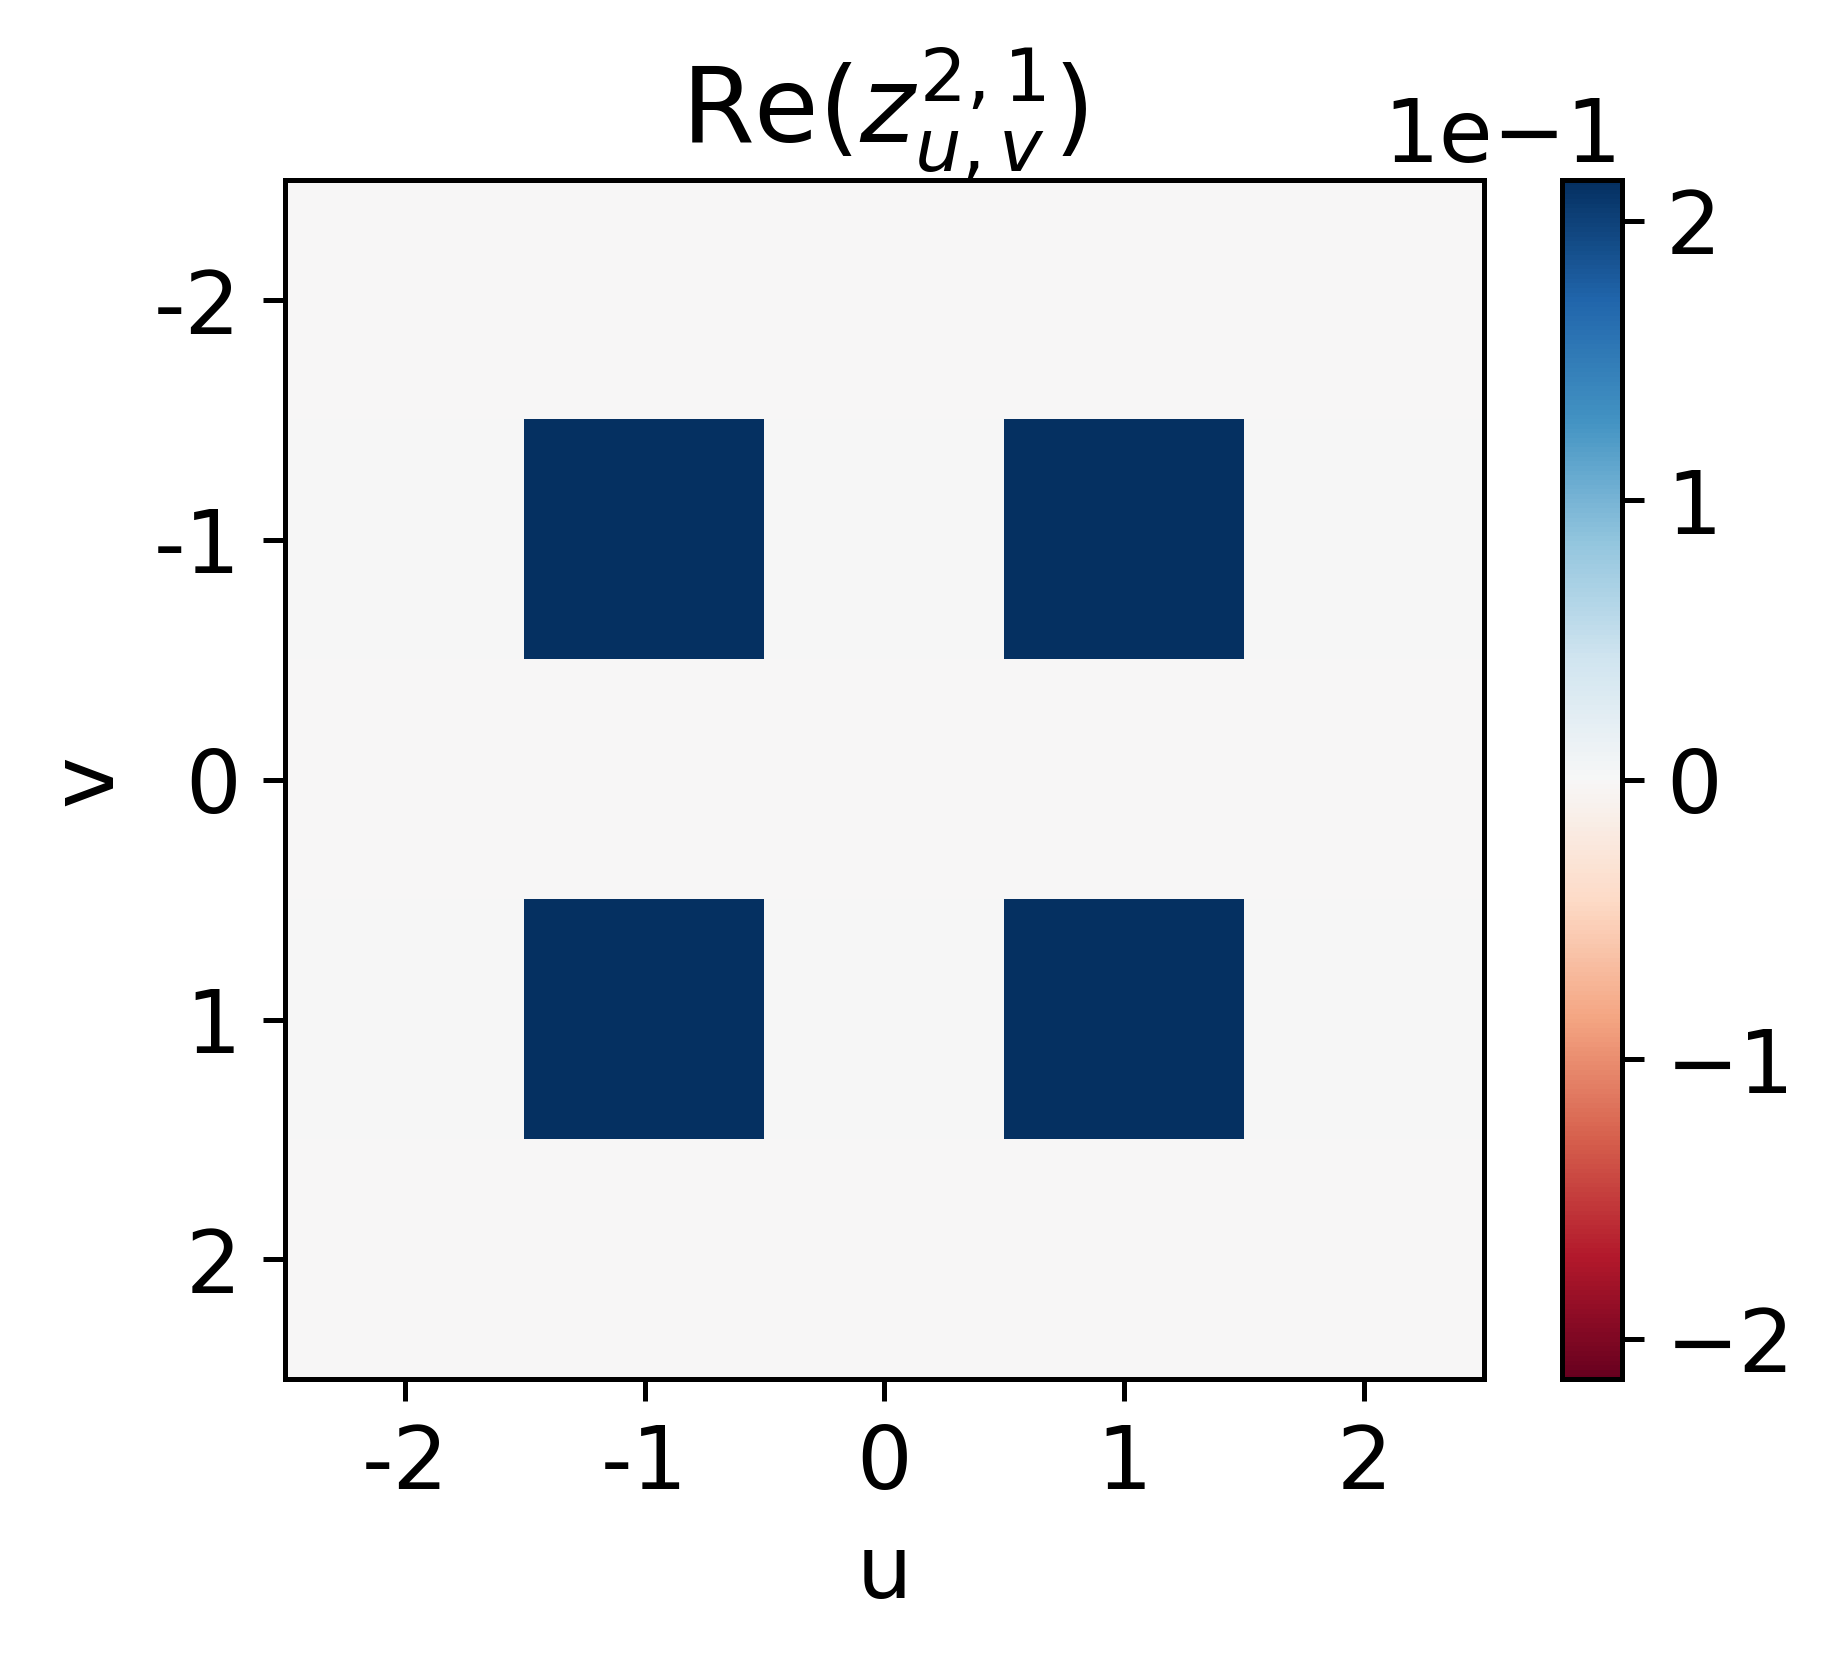

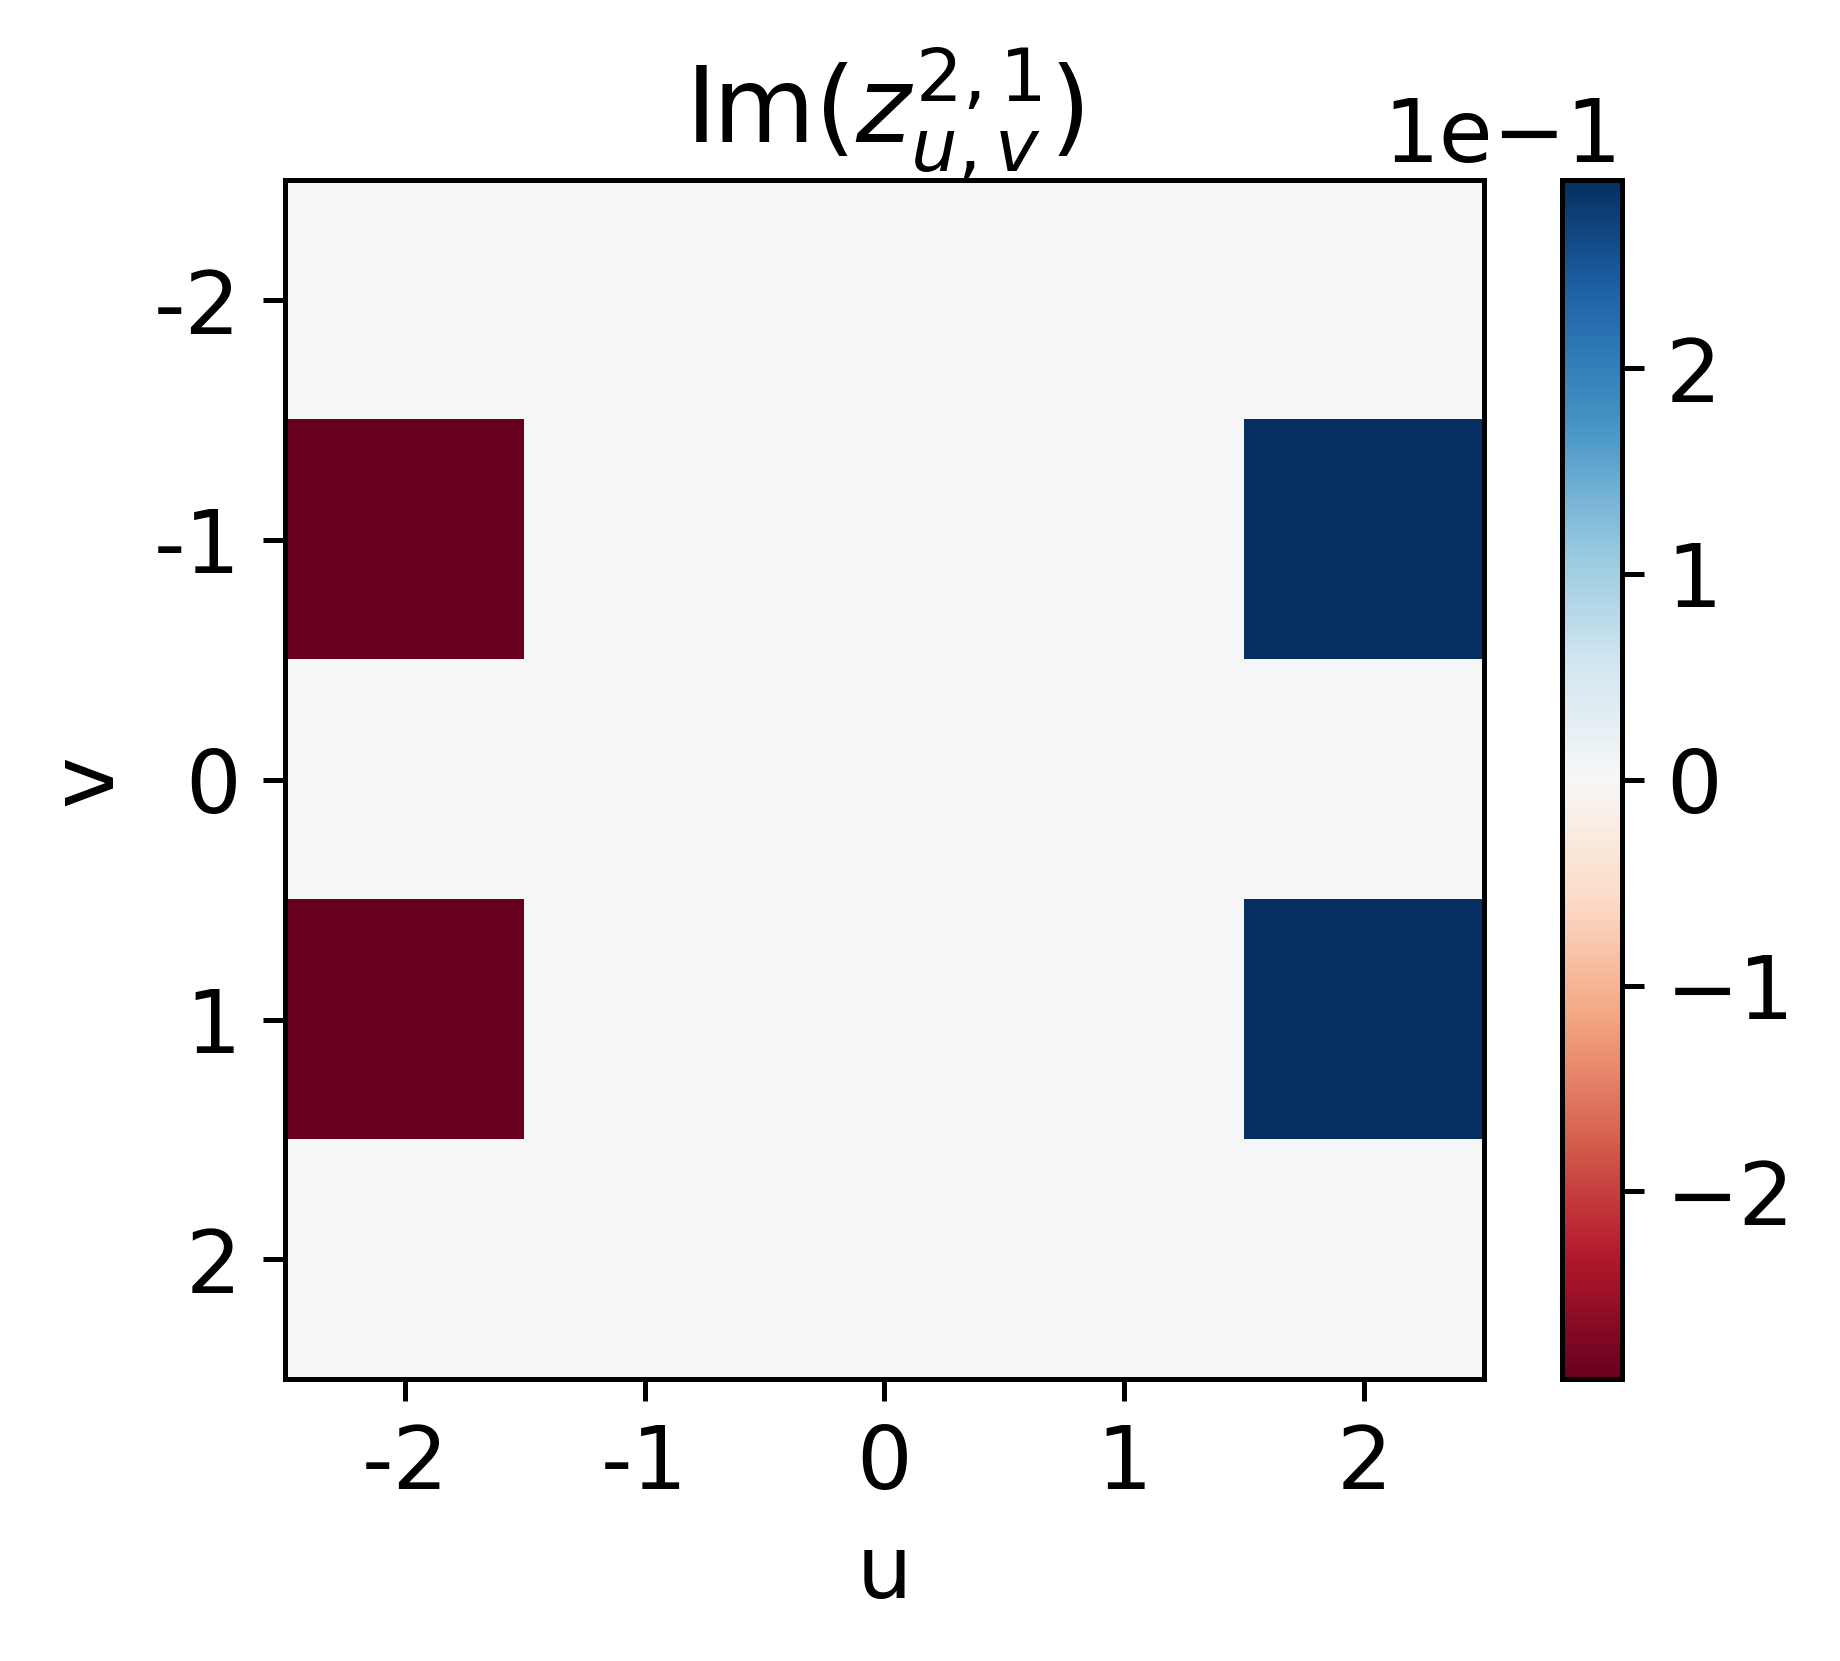

In [17]:
l, m = 2, 1
assert jnp.abs(m) <= l
z_lm = z_grid[gtp_utils.to_lm_index(l, m)]

plt.imshow(jnp.abs(z_lm).T, cmap="Grays", vmin=0)
plt.title("$|z_{{u, v}}^{{%d,%d}}|$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()


norm = mcolors.TwoSlopeNorm(vmin=-jnp.real(z_lm).max(), vcenter=0, vmax=jnp.real(z_lm).max())
plt.imshow(jnp.real(z_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Re}}(z_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()


norm = mcolors.TwoSlopeNorm(vmin=-jnp.imag(z_lm).max(), vcenter=0, vmax=jnp.imag(z_lm).max())
plt.imshow(jnp.imag(z_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Im}}(z_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()

In [18]:
# Transform SH coefficients to 2D Fourier coefficients
x1_lm = e3nn.normal(e3nn.s2_irreps(lmax), key=jax.random.PRNGKey(1)).array
x1_lm = x1_lm.at[gtp_utils.to_lm_index(2, -2):].set(0)
x1_uv = jnp.einsum("a,auv->uv", x1_lm, y_grid)
assert x1_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

x2_lm = e3nn.normal(e3nn.s2_irreps(lmax), key=jax.random.PRNGKey(2)).array
x2_lm = x2_lm.at[gtp_utils.to_lm_index(2, -2):].set(0)
x2_uv = jnp.einsum("a,auv->uv", x2_lm, y_grid)
assert x2_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

In [19]:
# Check that we can convert back to SH coefficients
x1_lm_reconstructed = jnp.einsum("uv,auv->a", x1_uv.conj(), z_grid)
print(x1_lm[0], x1_lm_reconstructed[0])
x1_lm, x1_lm_reconstructed, jnp.allclose(x1_lm, x1_lm_reconstructed, atol=5e-3)

-1.3524742133019472 (-1.3516926017142306-8.186735253235887e-19j)


(Array([-1.35247421, -0.2712502 , -0.02920518,  0.34706456,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ], dtype=float64),
 Array([-1.35169260e+00-8.18673525e-19j, -2.71249996e-01+4.36555525e-19j,
        -2.97425080e-02-5.15512290e-23j,  3.47064303e-01-5.92060979e-18j,
        -1.02827586e-16+0.00000000e+00j, -5.76382173e-07-3.55231375e-18j,
         1.74564707e-03+4.24041294e-19j,  7.37480849e-07-6.66942041e-18j,
        -1.56598050e-16+3.85185989e-34j], dtype=complex128),
 Array(True, dtype=bool))

In [20]:
x1 = jnp.asarray([[1 + 1j, 2], [3, 5]])
x2 = jnp.asarray([[6 + 2j, 8], [4 + 4j, 9]])

x1_x2_expected = gtp_utils.convolve_2D_direct(x1, x2)
x1_x2 = gtp_utils.convolve_2D_fft(x1, x2)

x1_x2, x1_x2_expected, np.isclose(x1_x2, x1_x2_expected, atol=1e-5)

(Array([[ 4.+8.00000000e+00j, 20.+1.20000000e+01j, 16.+3.45929943e-16j],
        [18.+1.40000000e+01j, 71.+2.70000000e+01j, 58.+4.54883535e-15j],
        [12.+1.20000000e+01j, 47.+2.00000000e+01j, 45.+1.47209505e-15j]],      dtype=complex128),
 Array([[ 4. +8.j, 20.+12.j, 16. +0.j],
        [18.+14.j, 71.+27.j, 58. +0.j],
        [12.+12.j, 47.+20.j, 45. +0.j]], dtype=complex128),
 array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

In [21]:
# Perform convolution manually
x1_x2_uv_manual = jnp.zeros((2 * 2 * lmax + 1, 2 * 2 * lmax + 1), dtype=jnp.complex64)
for u3 in range(-2 * lmax, 2 * lmax + 1):
    for v3 in range(-2 * lmax, 2 * lmax + 1):
        for u1 in range(-lmax, lmax + 1):
            for v1 in range(-lmax, lmax + 1):
                u2 = u3 - u1
                v2 = v3 - v1

                if not (-lmax <= u2 <= lmax and -lmax <= v2 <= lmax):
                    continue
                
                u1_index = gtp_utils.to_u_index(u1, lmax)
                v1_index = gtp_utils.to_v_index(v1, lmax)
                u2_index = gtp_utils.to_u_index(u2, lmax)
                v2_index = gtp_utils.to_v_index(v2, lmax)
                u3_index = gtp_utils.to_u_index(u3, 2 * lmax)
                v3_index = gtp_utils.to_v_index(v3, 2 * lmax)

                x1_x2_uv_manual = x1_x2_uv_manual.at[u3_index, v3_index].add(
                    x1_uv[u1_index, v1_index] * x2_uv[u2_index, v2_index]
                )

# Check that the convolution matches JAX.
x1_x2_uv_expected = jax.scipy.signal.convolve2d(x1_uv, x2_uv, mode='full')
print(jnp.isclose(x1_x2_uv_manual, x1_x2_uv_expected, atol=1e-3))

# Convert back to SH coefficients
x1_x2_lm_manual = jnp.einsum("uv,auv->a", x1_x2_uv_manual.conj(), big_z_grid)
print(x1_x2_lm_manual.imag.min(), x1_x2_lm_manual.imag.max())

/Users/ameyad/Documents/vector-spherical-harmonics/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]]
-1.4901161e-08 2.9802322e-08


In [22]:
x1_lm, x2_lm, x1_x2_lm_manual.round(2)

(Array([-1.35247421, -0.2712502 , -0.02920518,  0.34706456,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ], dtype=float64),
 Array([-0.41931145, -0.86238279, -0.50200338, -1.33984811,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ], dtype=float64),
 Array([ 0.62-0.j,  2.27-0.j,  1.22-0.j,  2.95+0.j,  0.09+0.j,  0.22+0.j,
         0.21+0.j, -0.19+0.j, -0.96-0.j,  0.  -0.j, -0.  -0.j, -0.  +0.j,
        -0.  +0.j, -0.  +0.j, -0.  -0.j,  0.  +0.j, -0.  +0.j,  0.  -0.j,
        -0.  -0.j,  0.  +0.j, -0.  +0.j,  0.  +0.j, -0.  -0.j,  0.  -0.j,
        -0.  -0.j], dtype=complex64))

In [23]:
print(x1_x2_lm_manual.imag.max(), x1_x2_lm_manual.imag.min())
product = e3nn.to_s2grid(e3nn.IrrepsArray(e3nn.s2_irreps(2 * lmax), x1_x2_lm_manual.real), res_beta=100, res_alpha=99, quadrature="soft")
go.Figure([go.Surface(product.plotly_surface())])


2.9802322e-08 -1.4901161e-08
